In [60]:
import yfinance as yf
import ta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

import datetime
import holidays 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [65]:
def display_metrics(df):
    # Calculating error metrics
    mse = mean_squared_error(df['Close'], df['preds'])
    print(f"Mean Squared Error (MSE): {mse:.4f}")

    rmse = mean_squared_error(df['Close'], df['preds'], squared=False)
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    mape = (abs(df['Close'] - df['preds']) / df['Close']).mean() * 100
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

In [ ]:
def plot_train_test(train, test,):
    plt.figure(figsize=(12, 6))

    # Plot the actual close prices from train data
    sns.lineplot(x=train.index, y=train['Close'], label="Train Data (Actual Close)", color="blue")

    # Plot the actual close prices from test data
    sns.lineplot(x=test.index, y=test['Close'], label="Test Data (Actual Close)", color="green")

    # Plot the naive random walk predictions for test data
    sns.lineplot(x=test.index, y=test['preds'], label="Test Data (Predicted)", color="red", linestyle="dashed")

    # Customize labels and title
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title("Train vs. Test Data: Actual vs Predictions (ON TEST DATA)")
    plt.legend()

    # Show the plot
    plt.show()
    

In [76]:
def plot_oos(df_actual, df_preds):
    ## Plotting Predictions
    # Plot the actual and predicted stock prices
    plt.figure(figsize=(12, 6))

    # Plot the actual close prices
    sns.lineplot(x=df_actual.index, y=df_actual['Close'], label="Actual Close Price", color="blue")

    # Plot the naive random walk predictions
    sns.lineplot(x=df_preds['dt'], y=df_preds['preds'], label="Prediction", color="red", linestyle="dashed")

    # Customize labels and title
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title("Actual vs. Predicted Stock Prices (OUT OF SAMPLE)")
    plt.legend()

    # Show the plot
    plt.show()

In [20]:
data = yf.Ticker("CAVA")

df = pd.DataFrame(data.history(period='max'))
##Filter to 3 years of history (if available)... else use all history
last_date = df.index[-1]
three_years_ago = last_date - pd.DateOffset(years=3)

if df.index[0] < three_years_ago:
    df_filtered = df[df.index >= three_years_ago]  # Use last 3 years
    print("Filtered to last 3 years: ", df_filtered.index.min())
else:
    df_filtered = df  # Use all data if less than 3 years
    print("Less than 3 years of data: ", df_filtered.index.min())
print(df_filtered.tail(3))
print(df_filtered[['Close']].describe())
std_dev = df_filtered['Close'].std()
print(std_dev)

Less than 3 years of data:  2023-06-16 00:00:00-04:00
                                Open       High        Low      Close  \
Date                                                                    
2025-03-19 00:00:00-04:00  77.510002  82.510002  76.654999  81.000000   
2025-03-20 00:00:00-04:00  82.620003  86.669998  81.699997  84.660004   
2025-03-21 00:00:00-04:00  83.330002  84.190002  81.129997  83.849998   

                            Volume  Dividends  Stock Splits  
Date                                                         
2025-03-19 00:00:00-04:00  4364800        0.0           0.0  
2025-03-20 00:00:00-04:00  5887300        0.0           0.0  
2025-03-21 00:00:00-04:00  3608700        0.0           0.0  
            Close
count  442.000000
mean    78.064638
std     36.877229
min     29.980000
25%     43.857500
50%     72.055000
75%    115.110003
max    150.880005
36.87722927981914


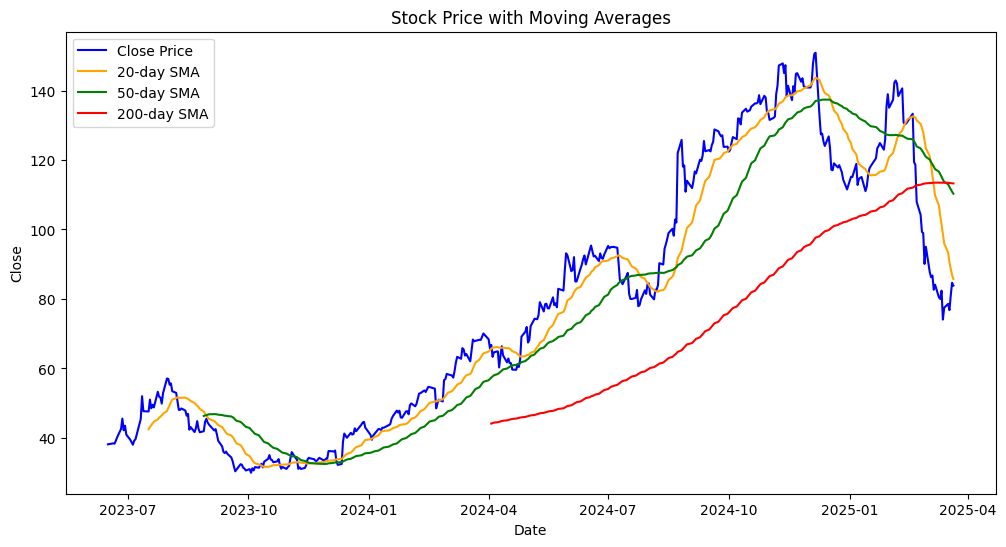

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Simple Moving Average (SMA)
df_filtered['SMA_20'] = df_filtered['Close'].rolling(window=20).mean()
df_filtered['SMA_50'] = df_filtered['Close'].rolling(window=50).mean()
df_filtered['SMA_200'] = df_filtered['Close'].rolling(window=200).mean()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_filtered.index, y=df_filtered['Close'], label="Close Price", color="blue")
sns.lineplot(x=df_filtered.index, y=df_filtered['SMA_20'], label="20-day SMA", color="orange")
sns.lineplot(x=df_filtered.index, y=df_filtered['SMA_50'], label="50-day SMA", color="green")
sns.lineplot(x=df_filtered.index, y=df_filtered['SMA_200'], label="200-day SMA", color="red")

plt.title("Stock Price with Moving Averages")
plt.show()

## 50-day moving average (SMA) crosses above the 200-day moving average (SMA), Bullish
# 50-day moving average (SMA) crosses below the 200-day moving average (SMA), Bearish


# Begin Modeling

In [46]:
## Test Data
test_data = df_filtered[["Close"]].tail(30).copy()
first_test_date = test_data.index[0] # To make train

# Train Data
train_data = df_filtered[df_filtered.index < first_test_date][["Close"]].copy()


In [70]:
## Constants for Modeling

df_to_model = df_filtered[['Close']].copy()
predictions_df = pd.DataFrame()
last_price = df_to_model['Close'].iloc[-1]
days_of_trading_to_predict = 100


## Creating future dates to predict
us_holidays = holidays.UnitedStates(years = [2025,2026])
current_datetime = datetime.datetime.today()
formatted_date = current_datetime.strftime("%d/%m/%Y")
future_dates = pd.date_range(start=formatted_date, periods=days_of_trading_to_predict, freq='B')
# Remove U.S. holidays from the generated business days
future_dates = [date for date in future_dates if date not in us_holidays]

# Keep only the first `days_of_trading_to_predict` valid trading days
future_dates = future_dates[:days_of_trading_to_predict]

predictions_df = pd.DataFrame({'dt': future_dates})

predictions_df

,dt
0,2025-03-24
1,2025-03-25
2,2025-03-26
3,2025-03-27
4,2025-03-28
...,...
92,2025-08-04
93,2025-08-05
94,2025-08-06
95,2025-08-07


## Naive Random Walk (Baseline)

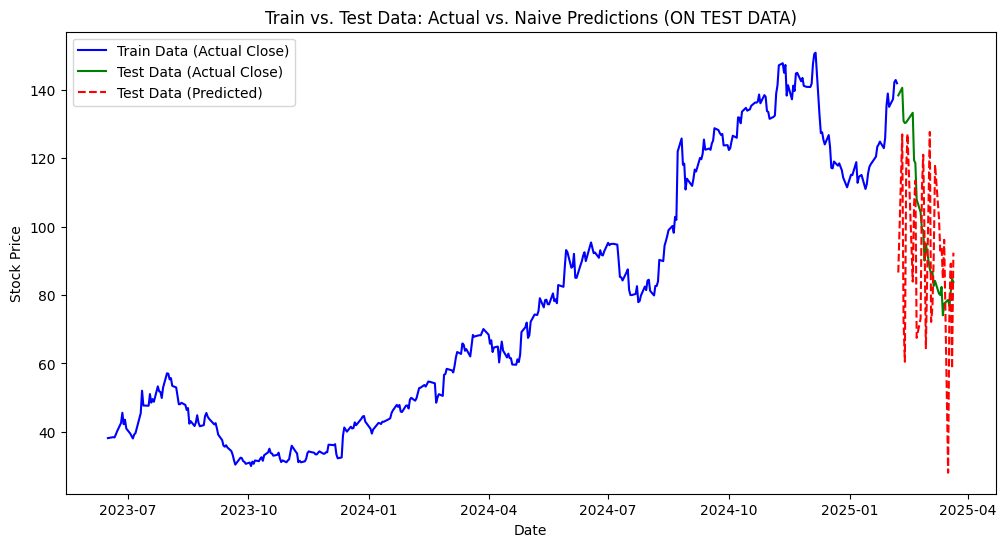

Mean Squared Error (MSE): 865.9601
Root Mean Squared Error (RMSE): 29.4272
Mean Absolute Percentage Error (MAPE): 22.99%


In [ ]:
## TEST

test_df_naive = test_data.copy()

mu = 0  # Mean return (0 for pure random walk)
std_dev = test_df_naive['Close'].std()
sigma = std_dev  # Standard deviation of returns

closes = np.random.normal(mu, sigma, len(test_data))
closes = closes + last_price

test_df_naive['preds'] = closes

plot_train_test(train_data, test_df_naive)
display_metrics(test_df_naive)

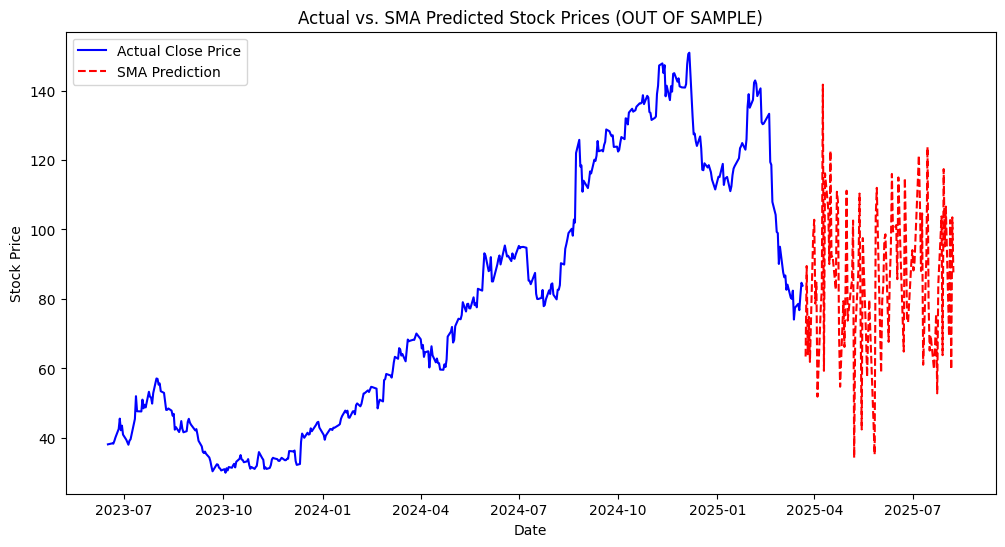

In [ ]:
## OUT OF SAMPLE
predictions_df_naive = predictions_df.copy()

# Generate random walk
closes = np.random.normal(mu, sigma, len(predictions_df_naive))
std_dev = df_to_model['Close'].std()
closes = closes + last_price

predictions_df_naive['preds'] = closes


## Plotting Predictions
plot_oos(df_to_model, predictions_df_naive)

## Simple Moving Average

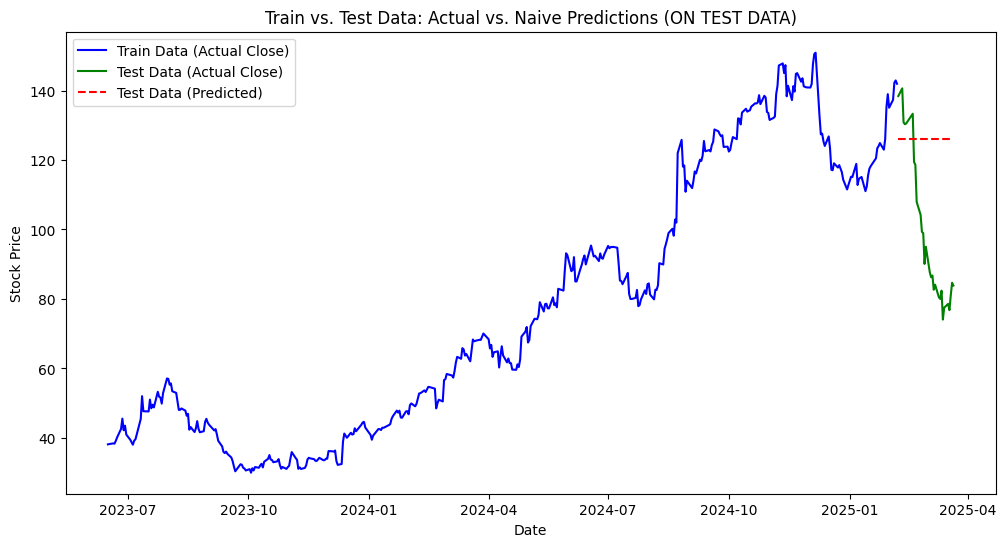

Mean Squared Error (MSE): 1154.9924
Root Mean Squared Error (RMSE): 33.9852
Mean Absolute Percentage Error (MAPE): 34.38%


In [81]:
## TEST

moving_avg_window = 20  # 20-day moving average
train_data['SMA_20'] = train_data['Close'].rolling(window=moving_avg_window).mean()

# Use the last value of the SMA as a baseline for future predictions
# We will predict that future stock prices (for test data) will follow the last known SMA value
last_sma_value = train_data['SMA_20'].iloc[-1]

# For the test data, predict using the last SMA value
test_df_ma = test_data.copy()
test_df_ma['preds'] = last_sma_value

# Plotting actual and predicted values
plot_train_test(train_data, test_df_ma)
display_metrics(test_df_ma)


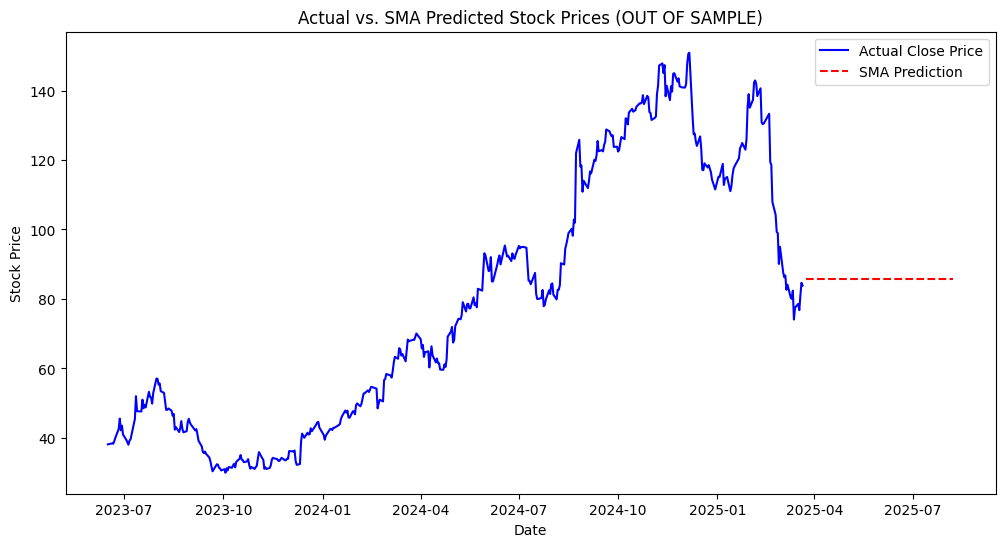

In [ ]:
## OUT OF SAMPLE
predictions_df_sma = predictions_df.copy()

moving_avg_window = 20  # 20-day moving average
df_to_model['SMA_20'] = df_to_model['Close'].rolling(window=moving_avg_window).mean()

last_sma_value = df_to_model['SMA_20'].iloc[-1]

predictions_df_sma = predictions_df.copy()
predictions_df_sma['preds'] = last_sma_value


## Plotting Predictions
plot_oos(df_to_model, predictions_df_sma)


## ARIMA